In [1]:
pwd 

'C:\\Users\\hamza\\Programs\\Road_Traffic_Monitoring_AI_Vision_Based_SMART_sensor\\Notebooks'

In [2]:
cd C:\Users\hamza\Programs\Road_Traffic_Monitoring_AI_Vision_Based_SMART_sensor\Notebooks

C:\Users\hamza\Programs\Road_Traffic_Monitoring_AI_Vision_Based_SMART_sensor\Notebooks


C:\Users\hamza\anaconda3\envs\smart_sensor\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
cd ..

C:\Users\hamza\Programs\Road_Traffic_Monitoring_AI_Vision_Based_SMART_sensor


In [4]:
import json
from typing import Sequence, Tuple, List, Dict, Any, Optional , Iterator
import re
from pathlib import Path
import yaml
import math
import os
import ast
import logging
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

base_path = Path(r"C:\Users\hamza\Datasets\TrafficDatasets\UA_DETRAC_Original")

save_path = Path("uadetrac_dataset/ua_detrac_annotations.csv")
annotations_df = pd.read_csv(save_path)

save_path = Path("uadetrac_dataset/uadetrac_vid_roi_ann.csv")
geometry_df = pd.read_csv(save_path, converters={"ROI": eval, "line": eval})

In [5]:
annotations_df.head(2)

,global_ann_id,xml_file,sequence,frame,video_track_id,global_track_id,category,bbox_x,bbox_y,bbox_w,...,x2,y2,area,density,orientation,speed,trajectory_length,truncation_ratio,video_ann_id,split
0,1,C:\Users\hamza\Datasets\TrafficDatasets\UA_DET...,MVI_20011,1,1,MVI_20011_track_1,car,592.75,378.80,160.05,...,752.80,541.00,25960.110,7,18.488,6.8590,5.0,0.1,0,train
1,2,C:\Users\hamza\Datasets\TrafficDatasets\UA_DET...,MVI_20011,1,2,MVI_20011_track_2,car,557.65,120.98,47.20,...,604.85,164.04,2032.432,7,19.398,1.5055,72.0,0.0,1,train


In [6]:
geometry_df.head(2)

,video,ROI,line
0,MVI_20011,"[[952, 163], [778, 86], [495, 76], [264, 531],...","[[824, 114], [324, 349]]"
1,MVI_20012,"[[803, 54], [471, 37], [241, 530], [954, 529],...","[[879, 78], [319, 363]]"


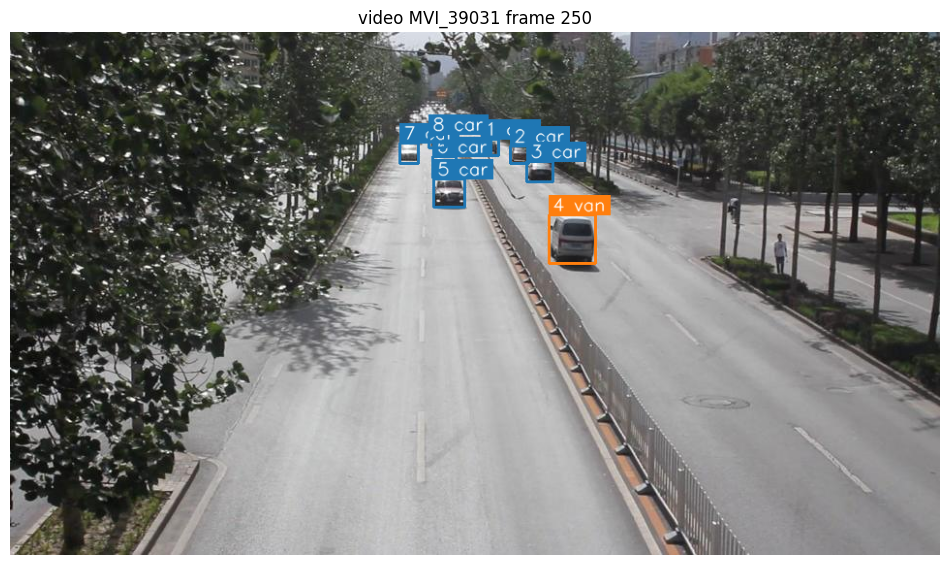

In [7]:
# ---- 1) get_frame_annotations ------------------------------------------------
def get_frame_annotations(sequence: str, frame: int) -> pd.DataFrame:
    """
    Return subset of annotations_df for given sequence and frame.
    """
    sel = annotations_df[
        (annotations_df['sequence'].astype(str) == str(sequence)) &
        (annotations_df['frame'].astype(int) == int(frame))
    ].copy()
    return sel

# ---- 2) find_frame_image_path ------------------------------------------------
def find_frame_image_path(sequence: str, frame: int , base_path: Path = base_path) -> Path:
    """
    Locate the image file for a given DETRAC sequence and frame number.
    Raises FileNotFoundError if not found.
    """
    base_path = Path(base_path)
    # common candidate folders
    candidates = [
        base_path / "DETRAC-Images" / "DETRAC-Images" / sequence,
    ]
    seq_dir = None
    for c in candidates:
        if c.exists() and c.is_dir():
            seq_dir = c
            break
    if seq_dir is None:
        matches = list(base_path.rglob(sequence))
        seq_dir = matches[0] if matches else None
    if seq_dir is None or not seq_dir.is_dir():
        raise FileNotFoundError(f"Sequence folder '{sequence}' not found under {base_path}")

    # file name heuristics
    def _padded(n, width=5): return str(n).zfill(width)
    patterns = [
        f"img{_padded(frame)}",
        f"img{frame}",
        f"frame_{_padded(frame)}",
        f"frame_{frame}",
        f"{_padded(frame)}",
        str(frame)
    ]
    img_path = None
    files = sorted([p for p in seq_dir.iterdir() if p.is_file()])
    for p in files:
        name = p.stem.lower()
        if any(pat in name for pat in patterns) and p.suffix.lower() in ('.jpg','.jpeg','.png','.bmp','.tif','.tiff'):
            img_path = p
            break

    # fallback: index = frame-1
    if img_path is None:
        idx = frame - 1
        image_files = [p for p in files if p.suffix.lower() in ('.jpg','.jpeg','.png','.bmp','.tif','.tiff')]
        if 0 <= idx < len(image_files):
            img_path = image_files[idx]

    if img_path is None:
        raise FileNotFoundError(f"Could not locate image for sequence={sequence} frame={frame} in {seq_dir}")

    return img_path

# ---- 3) annotate_image -------------------------------------------------------
def annotate_image(image_rgb: np.ndarray,
                   anns: pd.DataFrame,
                   box_thickness: int = 2,
                   font_scale: float = 0.6) -> np.ndarray:
    """
    Draw bounding boxes, video_track_id and category onto an RGB image and return annotated RGB image.
    """
    img = image_rgb.copy()
    H, W = img.shape[:2]

    # build category -> color map (deterministic)
    unique_cats = sorted(anns['category'].dropna().unique().astype(str)) if not anns.empty else []

    cmap = plt.colormaps.get_cmap('tab10')
    unique_cats = sorted(anns['category'].dropna().unique().astype(str)) if not anns.empty else []
    cat2color = {
        cat: tuple(int(c * 255) for c in cmap(i % cmap.N)[:3])
        for i, cat in enumerate(unique_cats)
    }

    for _, r in anns.iterrows():
        x = float(r.get('bbox_x', 0)); y = float(r.get('bbox_y', 0))
        w_box = float(r.get('bbox_w', 0)); h_box = float(r.get('bbox_h', 0))
        x1 = int(round(x)); y1 = int(round(y))
        x2 = int(round(x + w_box)); y2 = int(round(y + h_box))
        # clamp
        x1 = max(0, min(W-1, x1)); x2 = max(0, min(W-1, x2))
        y1 = max(0, min(H-1, y1)); y2 = max(0, min(H-1, y2))

        cat = str(r.get('category', 'unknown'))
        color = cat2color.get(cat, (255, 0, 255))
        # draw rectangle (RGB)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=box_thickness)

        # label: track id + category
        track = r.get('video_track_id', r.get('track_id', None))
        try:
            track_label = f"{int(track)}" if (track is not None and not pd.isna(track)) else ""
        except Exception:
            track_label = str(track)
        label = f"{track_label} {cat}".strip()

        ((tw, th), _) = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
        bg_y1 = max(0, y1 - th - 6); bg_y2 = y1
        bg_x1 = x1; bg_x2 = x1 + tw + 8
        cv2.rectangle(img, (bg_x1, bg_y1), (bg_x2, bg_y2), color, -1)
        cv2.putText(img, label, (x1 + 4, y1 - 4), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), thickness=1, lineType=cv2.LINE_AA)

    return img

# ---- 4) show_image -----------------------------------------------------------
def show_image(img_rgb: np.ndarray, title: str = "", save_path: Optional[Path] = None, figsize: Tuple[int,int] = (12,8)) -> None:
    """
    Display an RGB image with matplotlib and optionally save it (PNG/JPG).
    """
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.axis('off')
    if title:
        plt.title(title)
    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        # convert RGB -> BGR for cv2.imwrite
        cv2.imwrite(str(save_path), cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    plt.show()




sequence = "MVI_39031"
frame = 250

anns = get_frame_annotations(sequence=sequence, frame=frame)
img_path = find_frame_image_path(sequence=sequence, frame=frame) 
img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
annotated = annotate_image(img, anns)
show_image(annotated, title=f"video {sequence} frame {frame}")

## GeoAnnotation Visualization:

In [8]:
from framegrabber.frame_grabber import UADETRACFrameGrabber

In [9]:
fg = UADETRACFrameGrabber()         
fg.open_sequence("MVI_20051")      
# random access (DETRAC 1-based)
idx, frame, path = fg.get_frame(10)
path

WindowsPath('C:/Users/hamza/Datasets/TrafficDatasets/UA_DETRAC_Original/DETRAC-Images/DETRAC-Images/MVI_20051/img00010.jpg')

In [10]:
fg = UADETRACFrameGrabber()         
fg.open_by_index(20)      
# random access (DETRAC 1-based)
idx, frame, path = fg.get_frame(10)
idx , path

(10,
 WindowsPath('C:/Users/hamza/Datasets/TrafficDatasets/UA_DETRAC_Original/DETRAC-Images/DETRAC-Images/MVI_39401/img00010.jpg'))

In [11]:
class AnnotatedSequencePlayer:
    def __init__(self, frame_grabber=None, base_path: Optional[Path]=None, monitor_resolution: Tuple[int,int]=(1000,2000)):
        """
        Provide either a FrameGrabber instance or base_path (player will construct a FrameGrabber).
        """
        if frame_grabber is not None:
            self.grabber = frame_grabber
        else:
            from pathlib import Path as _P
            from copy import deepcopy
            # lazy import/construct FrameGrabber from caller scope
            try:
                FG = globals().get('FrameGrabber')
                if FG is None:
                    raise RuntimeError("FrameGrabber class not found in globals()")
                self.grabber = FG(base_path=Path(base_path) if base_path is not None else None)
            except Exception as e:
                raise RuntimeError(f"Could not construct FrameGrabber: {e}")
        self.monitor_h, self.monitor_w = int(monitor_resolution[0]), int(monitor_resolution[1])

    # --- geo annotate helper (same as before) ---
    @staticmethod
    def _to_int_pts(pts: Sequence[Sequence[float]]) -> np.ndarray:
        arr = np.asarray(pts, dtype=float)
        if arr.ndim == 1 and arr.size == 2:
            arr = arr.reshape((1,2))
        return arr.astype(np.int32)

    def _geo_annotate_frame(self, frame: np.ndarray,
                            roi: Optional[Sequence[Sequence[int]]]=None,
                            line: Optional[Sequence[Sequence[int]]]=None,
                            roi_color: Tuple[int,int,int]=(0,180,255),
                            line_color: Tuple[int,int,int]=(0,0,255),
                            roi_alpha: float=0.25, thickness: int=2) -> np.ndarray:
        out = frame.copy()
        h,w = out.shape[:2]
        if roi:
            pts = self._to_int_pts(roi); pts[:,0]=np.clip(pts[:,0],0,w-1); pts[:,1]=np.clip(pts[:,1],0,h-1)
            overlay = out.copy(); cv2.fillPoly(overlay,[pts], color=roi_color)
            cv2.addWeighted(overlay, roi_alpha, out, 1-roi_alpha, 0, out)
            cv2.polylines(out,[pts], isClosed=True, color=roi_color, thickness=thickness)
        if line and len(line) >= 2:
            p = self._to_int_pts(line); p1=(int(p[0,0]),int(p[0,1])); p2=(int(p[1,0]),int(p[1,1]))
            cv2.line(out,p1,p2,color=line_color,thickness=thickness,lineType=cv2.LINE_AA)
            cv2.circle(out,p1,radius=max(3,thickness+1),color=line_color,thickness=-1)
            cv2.circle(out,p2,radius=max(3,thickness+1),color=line_color,thickness=-1)
        return out

    # --- geometry lookup ---
    def _find_geometry_for_sequence(self, geometry_df: Optional[pd.DataFrame], sequence: str):
        if geometry_df is None:
            return None, None
        try:
            mask = geometry_df['video'].astype(str).apply(lambda s: Path(s).stem == Path(sequence).stem)
            if not mask.any():
                return None, None
            row = geometry_df.loc[mask].iloc[0]
            roi = row.get("ROI", None); line = row.get("line", None)
            if isinstance(roi, str): roi = ast.literal_eval(roi)
            if isinstance(line, str): line = ast.literal_eval(line)
            return roi, line
        except Exception:
            return None, None

    def _has_sequence(self, df: pd.DataFrame, seq: str) -> bool:
        try:
            return seq in set(df['sequence'].astype(str).unique())
        except Exception:
            return False

    # --- core play using FrameGrabber ---
    def play(self,
             sequence: Optional[str]=None,
             video_idx: Optional[int]=None,
             annotations_df: Optional[pd.DataFrame]=None,
             geometry_df: Optional[pd.DataFrame]=None,
             play_fps: int = 25,
             window_name: str = "Annotated Sequence",
             save_path: Optional[Path] = None,
             box_thickness: int = 2,
             font_scale: float = 0.6,
             scale: float = 1.0,
             show_geometry: bool = True) -> Optional[Path]:

        # open sequence via grabber (index or name)
        if sequence is None and video_idx is not None:
            self.grabber.open_by_index(video_idx)
            sequence = self.grabber.sequence_dir.name
        elif sequence is not None:
            self.grabber.open_sequence(sequence)
        else:
            raise ValueError("Either sequence or video_idx must be provided.")

        # choose annotations df containing this sequence
        if annotations_df is None:
            raise FileNotFoundError(f"Sequence '{sequence}' not found in provided annotations")
        
        # geometry
        roi, line = (None, None)
        if show_geometry and geometry_df is not None:
            roi, line = self._find_geometry_for_sequence(geometry_df, sequence)
        if roi is None and line is None:
            show_geometry = False

        # prepare writer if requested (use first frame to get dims)
        writer = None
        if save_path is not None:
            idx0, frame0, _ = self.grabber.get_frame(1)
            h0,w0 = frame0.shape[:2]
            w_out, h_out = int(w0 * scale), int(h0 * scale)
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(str(save_path), fourcc, play_fps, (w_out, h_out))

        delay_ms = int(1000 / play_fps) if play_fps > 0 else 1
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

        try:
            # iterate frames via grabber.frames() (1-based)
            for idx, frame_bgr, path in self.grabber.frames(start=1):
                # detection boxes -> user-provided functions in caller scope
                rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                anns = get_frame_annotations(sequence, idx)
                annotated_rgb = annotate_image(rgb, anns, box_thickness=box_thickness, font_scale=font_scale)
                annotated_bgr = cv2.cvtColor(annotated_rgb, cv2.COLOR_RGB2BGR)

                if show_geometry:
                    annotated_bgr = self._geo_annotate_frame(annotated_bgr, roi=roi, line=line)

                # scaling for display / writer
                if scale != 1.0:
                    new_w = int(annotated_bgr.shape[1] * scale)
                    new_h = int(annotated_bgr.shape[0] * scale)
                    annotated_disp = cv2.resize(annotated_bgr, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
                else:
                    annotated_disp = annotated_bgr

                cv2.imshow(window_name, annotated_disp)
                if writer is not None:
                    # writer should receive same sized frames as initialized (we wrote scaled dims)
                    writer.write(annotated_disp)

                key = cv2.waitKey(delay_ms) & 0xFF
                if key in (ord('q'), 27):
                    break
        finally:
            cv2.destroyAllWindows()
            if writer is not None:
                writer.release()

        return Path(save_path) if save_path is not None else None

    # convenience wrappers
    def play_by_sequence(self, sequence: str, **kwargs) -> Optional[Path]:
        return self.play(sequence=sequence, **kwargs)

    def play_by_index(self, video_idx: int, **kwargs) -> Optional[Path]:
        return self.play(video_idx=video_idx, **kwargs)



# 1) create grabber (points to base folder containing sequences)
fg = UADETRACFrameGrabber()

# 2) create player that uses this grabber
player = AnnotatedSequencePlayer(frame_grabber=fg)

# # 3) play by sequence name (live display; do not save)
# player.play_by_sequence(
#     "MVI_39361",
#     annotations_df=annotations_df,
#     geometry_df=geometry_df,
#     play_fps=24,
#     scale=0.8,
#     show_geometry=True,
#     save_path=None
# )

# 4) play by index (0-based): open the N-th folder under base
player.play_by_index(
    71,
    annotations_df=annotations_df,
    geometry_df=geometry_df,
    play_fps=40,
    scale=1.0,
    show_geometry=True
)

## Generate Counting Annotations For UA-DETRAC with respect to the geometric filtring applied

In [12]:
import time

#####################################################################################################################################

import cv2
import numpy as np

In [13]:
# def get_frame_annotations(annotations_df: pd.DataFrame, sequence: str, frame: int) -> np.ndarray:
#     # Filter rows for the given sequence and frame
#     df = annotations_df[(annotations_df["sequence"] == sequence) & (annotations_df["frame"] == frame)]

#     if df.empty:
#         return np.zeros((0, 8), dtype=float)

#     # Map categories to integer class IDs
#     category_map = {"car": 0, "van": 1, "others": 2, "bus": 3}
#     cls = df["category"].map(category_map).fillna(-1).astype(int)

#     # Build array: [x1, y1, x2, y2, id, conf, cls, ind]
#     arr = np.stack([
#         df["x1"].values,
#         df["y1"].values,
#         df["x2"].values,
#         df["y2"].values,
#         df["video_track_id"].values,
#         np.ones(len(df)),     # conf = 1.0
#         cls.values,
#         np.zeros(len(df))     # ind = 0
#     ], axis=1)

#     return arr.astype(float)

In [14]:
# sequence = "MVI_39031"
# frame = 1000

# res = get_frame_annotations(annotations_df , sequence, frame)
# res

In [ ]:
# map_logics = dict()
# logics = [["by_id"] , ["by_cross_id"] , ["by_id" , "by_vicinity"] , ["by_cross_id" , "by_vicinity"]  , ["by_cross_id" , "by_id" , "by_vicinity"]]
# for i , logic in enumerate(logics):
#     map_logics[f"Method_{i+1}"] = logic
# map_logics

In [ ]:
# from counting.count_config_loader import CountingConfigLoader

In [ ]:
# counter_load = CountingConfigLoader(frame_size = 900)

# cfg = counter_load._read_yaml(counter_load.config_path)
# rois_raw = cfg.get("rois") or []
# global_raw = cfg.get("global") or None
# roi = rois_raw[0]          # ["by_cross_id" , "by_id" , "by_vicinity"]

In [ ]:
# counting_logic , polygon , line , line_vicinity = ["by_id"] , geometry_df["ROI"][0] , geometry_df["line"][0] , 0.15
# roi["counting_logic"] , roi["polygon"] , roi["line"] , roi["line_vicinity"] = counting_logic , polygon , line , line_vicinity

In [ ]:
# counter = counter_load._normalize_roi(roi , 0)
# counter.line_vicinity

In [ ]:
# import json
# import copy
# import logging
# from pathlib import Path
# from tqdm import tqdm
# import time
# from datetime import datetime

# from framegrabber.frame_grabber import UADETRACFrameGrabber
# from counting.count_config_loader import CountingConfigLoader

# import numpy as np
# import pandas as pd

# base_path = Path(r"C:\Users\hamza\Datasets\TrafficDatasets\UA_DETRAC_Original")

# save_path = Path("uadetrac_dataset/ua_detrac_annotations.csv")
# annotations_df = pd.read_csv(save_path)

# save_path = Path("uadetrac_dataset/uadetrac_vid_roi_ann.csv")
# geometry_df = pd.read_csv(save_path, converters={"ROI": eval, "line": eval})


# # reduce noisy warnings (adjust as needed)
# logging.getLogger().setLevel(logging.WARNING)

# # ---------- Config / I/O ----------
# RESULTS_DIR = Path("uadetrac_dataset__")
# RESULTS_DIR.mkdir(exist_ok=True)

# RESULTS_FILE = RESULTS_DIR / "uadetrac_geo_counts_all.json"

# LINE_VICINITY = 0.15
# FPS = 25

# # class map and counting map required by your spec
# CLASS_MAP = {"car": 0, "van": 1, "others": 2, "bus": 3}
# COUNTING_MAP = {
#     "counter_1": ["by_id"],
#     "counter_2": ["by_cross_id"],
#     "counter_3": ["by_id", "by_vicinity"],
#     "counter_4": ["by_cross_id", "by_vicinity"],
#     "counter_5": ["by_cross_id", "by_id", "by_vicinity"],
# }

# # sequences to process (from annotations_df)
# sequences = list(annotations_df["sequence"].unique())
# counter_load = CountingConfigLoader(frame_size = 900)


# def get_frame_annotations(annotations_df: pd.DataFrame, sequence: str, frame: int) -> np.ndarray:
#     # Filter rows for the given sequence and frame
#     df = annotations_df[(annotations_df["sequence"] == sequence) & (annotations_df["frame"] == frame)]

#     if df.empty:
#         return np.zeros((0, 8), dtype=float)

#     # Map categories to integer class IDs
#     category_map = {"car": 0, "van": 1, "others": 2, "bus": 3}
#     cls = df["category"].map(category_map).fillna(-1).astype(int)

#     # Build array: [x1, y1, x2, y2, id, conf, cls, ind]
#     arr = np.stack([
#         df["x1"].values,
#         df["y1"].values,
#         df["x2"].values,
#         df["y2"].values,
#         df["video_track_id"].values,
#         np.ones(len(df)),     # conf = 1.0
#         cls.values,
#         np.zeros(len(df))     # ind = 0
#     ], axis=1)

#     return arr.astype(float)

# # ---------- helpers ----------
# def _make_prev_bycls(counter):
#     arr = getattr(counter.count_result, "counts_by_class", None)
#     if isinstance(arr, np.ndarray) and arr.size > 0:
#         return arr.copy().astype(int)
#     if arr is None:
#         return np.zeros(0, dtype=int)
#     return np.asarray(arr, dtype=int).copy()

# def _safe_get_split_for_sequence(annotations_df, sequence):
#     try:
#         mask = annotations_df['sequence'].astype(str) == str(sequence)
#         if mask.any() and 'split' in annotations_df.columns:
#             return str(annotations_df.loc[mask, 'split'].iloc[0])
#     except Exception:
#         pass
#     return "unknown"

# def _load_or_init_results(path: Path):
#     if path.exists():
#         try:
#             with path.open("r", encoding="utf-8") as fh:
#                 return json.load(fh)
#         except Exception:
#             # corrupt or unreadable -> start fresh but keep a backup
#             backup = path.with_suffix(".broken.json")
#             path.rename(backup)
#             return {"meta": {}, "sequences": {}}
#     return {"meta": {}, "sequences": {}}

# def _atomic_write_json(path: Path, data):
#     tmp = path.with_suffix(".tmp.json")
#     with tmp.open("w", encoding="utf-8") as fh:
#         json.dump(data, fh, ensure_ascii=False, indent=2)
#     tmp.replace(path)

# # ---------- prepare top-level file (may be updated later) ----------
# all_results = _load_or_init_results(RESULTS_FILE)

# # create meta if missing / update timestamp
# all_results["meta"] = {
#     "tool": "UA-Detrac GeoCount GT",
#     "version": "1.0",
#     "timestamp_utc": datetime.utcnow().isoformat() + "Z",
#     "fps": FPS,
#     "class_map": CLASS_MAP,
#     "counting_map": COUNTING_MAP,
#     "description": (
#         "Per-sequence geometric counting ground-truth for the UA-DETRAC dataset: "
#         "stores ROI/line parameters and per-logic totals, per-class breakdowns "
#         "(optional per-frame counts), plus timing metadata — contains results for ALL videos "
#         "(sequences); intended as reproducible ground truth for benchmarking AI vision–based vehicle counting systems."
#     )
# }
# if "sequences" not in all_results:
#     all_results["sequences"] = {}

# # ---------- main loop (sequences) ----------
# seq_pbar = tqdm(sequences, desc="Sequences", unit="seq")
# for sequence in seq_pbar:
#     # skip sequence if already present (checkpoint)
#     if str(sequence) in all_results["sequences"]:
#         seq_pbar.set_postfix_str(f"{sequence} (skipped)")
#         continue

#     # prepare frame grabber for this sequence
#     fg = UADETRACFrameGrabber()             # use your FrameGrabber
#     try:
#         fg.open_sequence(sequence)
#     except Exception as e:
#         logging.warning(f"Could not open sequence {sequence}: {e}")
#         # record failure entry and continue
#         all_results["sequences"][str(sequence)] = {
#             "split": _safe_get_split_for_sequence(annotations_df, sequence),
#             "num_frames": 0,
#             "roi": None,
#             "line": None,
#             "line_vicinity": LINE_VICINITY,
#             "by_logic": {},
#             "error": str(e)
#         }
#         _atomic_write_json(RESULTS_FILE, all_results)
#         continue

#     # geometry lookup by stem match
#     geom_mask = geometry_df['video'].astype(str).apply(lambda s: Path(s).stem == Path(sequence).stem)
#     if geom_mask.any():
#         geom_row = geometry_df.loc[geom_mask].iloc[0]
#         polygon = geom_row.get("ROI", None)
#         line = geom_row.get("line", None)
#     else:
#         polygon, line = None, None

#     # instantiate counters according to COUNTING_MAP
#     counters = {}
#     for i, (cname, logic_list) in enumerate(COUNTING_MAP.items(), start=1):
#         roi_template = {
#             "name": cname,
#             "enable": True,
#             "polygon": polygon,
#             "box_in_polygon_mode": "center_in_polygon",
#             "line": line,
#             "line_vicinity": LINE_VICINITY,
#             "counting_logic": logic_list
#         }
#         counters[cname] = counter_load._normalize_roi(copy.deepcopy(roi_template), 0)

#     # initial cumulative state
#     prev_totals = {name: int(getattr(c.count_result, "total_count", 0)) for name, c in counters.items()}
#     prev_bycls = {name: _make_prev_bycls(c) for name, c in counters.items()}

#     # per-frame storage
#     per_frame_store = {name: {"total": [], "by_class": [], "timing_sec": []} for name in counters}

#     # process frames (no inner tqdm to keep console compact)
#     for frame_idx, frame_bgr, frame_path in fg.frames(start=1):
#         # get annotations for this frame (your function must exist in scope)
#         anns = get_frame_annotations(annotations_df, sequence, frame_idx)

#         for name, counter in counters.items():
#             t0 = time.perf_counter()
#             result = counter.count(anns)
#             t1 = time.perf_counter()

#             frame_time = float(t1 - t0)
#             curr_total = int(getattr(result, "total_count", 0))
#             curr_bycls = getattr(result, "counts_by_class", None)
#             curr_bycls = np.asarray(curr_bycls, dtype=int) if curr_bycls is not None else np.zeros(0, dtype=int)

#             # align lengths and get per-frame increments
#             max_len = max(prev_bycls[name].size, curr_bycls.size)
#             if max_len == 0:
#                 per_frame_by_class = []
#                 prev_bycls[name] = np.zeros(0, dtype=int)
#             else:
#                 prev_pad = np.pad(prev_bycls[name], (0, max_len - prev_bycls[name].size), mode='constant')
#                 curr_pad = np.pad(curr_bycls, (0, max_len - curr_bycls.size), mode='constant')
#                 per_frame_by_class = (curr_pad - prev_pad).tolist()
#                 prev_bycls[name] = curr_pad.copy()

#             per_frame_total = curr_total - prev_totals.get(name, 0)
#             prev_totals[name] = curr_total

#             per_frame_store[name]["total"].append(int(per_frame_total))
#             per_frame_store[name]["by_class"].append(per_frame_by_class)
#             per_frame_store[name]["timing_sec"].append(frame_time)

#         # update single progress bar postfix
#         seq_pbar.set_postfix_str(f"{sequence} {frame_idx}/{fg.frame_count}")

#     # build sequence entry (video-level metadata stored here)
#     seq_entry = {
#         "split": _safe_get_split_for_sequence(annotations_df, sequence),
#         "num_frames": int(fg.frame_count),
#         "roi": polygon,
#         "line": line,
#         "line_vicinity": LINE_VICINITY,
#         "by_logic": {}
#     }

#     # populate by_logic results
#     for name in counters:
#         times = per_frame_store[name]["timing_sec"]
#         seq_entry["by_logic"][name] = {
#             "total_count": int(prev_totals.get(name, 0)),
#             "counts_by_class": prev_bycls[name].tolist() if isinstance(prev_bycls[name], np.ndarray) else [],
#             "per_frame_counts": per_frame_store[name]["total"],
#             "per_frame_counts_by_class": per_frame_store[name]["by_class"],
#             "per_frame_timing_sec": per_frame_store[name]["timing_sec"],
#             "total_time_sec": float(sum(times)),
#             "avg_time_sec": float(np.mean(times)) if times else 0.0,
#         }

#     # insert into global results and checkpoint write
#     all_results["sequences"][str(sequence)] = seq_entry
#     # update meta timestamp
#     all_results["meta"]["timestamp_utc"] = datetime.utcnow().isoformat() + "Z"
#     _atomic_write_json(RESULTS_FILE, all_results)

# seq_pbar.close()
# print(f"Saved overall results to: {RESULTS_FILE.resolve()}")

## Running vehicle counting algorithms on UADETRAC

In [13]:
pwd

'C:\\Users\\hamza\\Programs\\Road_Traffic_Monitoring_AI_Vision_Based_SMART_sensor'

Make sure you are in the working directory: 
* Road_Traffic_Monitoring_AI_Vision_Based_SMART_sensor

In [2]:
cd ..

C:\Users\hamza\Programs\Road_Traffic_Monitoring_AI_Vision_Based_SMART_sensor


C:\Users\hamza\anaconda3\envs\smart_sensor\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [14]:
# uadetrac_geo_count_pipeline.py
import json
import copy
import logging
from pathlib import Path
from tqdm import tqdm
import time
from datetime import datetime

import numpy as np
import pandas as pd
import torch

# local packages (make sure these module paths are correct in your environment)
from framegrabber.frame_grabber import UADETRACFrameGrabber
from detection.ultralytics_detectors import UltralyticsDetector
from tracking.track import Tracker
from counting.count_config_loader import CountingConfigLoader
from utils.profilers import Profile

# -----------------------
# Configuration / I/O
# -----------------------
logging.getLogger().setLevel(logging.WARNING)

BASE_PATH = Path(r"C:\Users\hamza\Datasets\TrafficDatasets\UA_DETRAC_Original")

ANNOTATIONS_CSV = Path("uadetrac_dataset/ua_detrac_annotations.csv")
GEOMETRY_CSV = Path("uadetrac_dataset/uadetrac_vid_roi_ann.csv")

annotations_df = pd.read_csv(ANNOTATIONS_CSV)
geometry_df = pd.read_csv(GEOMETRY_CSV, converters={"ROI": eval, "line": eval})

RESULTS_DIR = Path("uadetrac_dataset")
RESULTS_DIR.mkdir(exist_ok=True)
RESULTS_FILE = RESULTS_DIR / "uadetrac_yolov8_ocsort_geo_counts.json"

# per-sequence random vicinities (example)
TRACKLESS_VICINITY = np.random.uniform(0.01, 0.04, size=100)
TRACK_VICINITY = np.random.uniform(0.1, 0.15, size=100)

FPS = 25

# class map (used in meta)
CLASS_MAP = {
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    5: "bus",
    7: "truck",
}

# counting logics (fixed)
COUNTING_MAP = {
    "counter_0": ["by_vicinity"],
    "counter_1": ["by_id"],
    "counter_2": ["by_cross_id"],
    "counter_3": ["by_id", "by_vicinity"],
    "counter_4": ["by_cross_id", "by_vicinity"],
    "counter_5": ["by_cross_id", "by_id", "by_vicinity"],
}

# sequences from annotations
sequences = list(annotations_df["sequence"].unique())
counter_load = CountingConfigLoader(frame_size=900)

# -----------------------
# Instantiate detector & tracker (adjust args as needed)
# -----------------------
# NOTE: you must ensure UltralyticsDetector and Tracker constructors below
# match your actual classes / arguments.
my_model = UltralyticsDetector("yolov8n.pt", conf=0.1)     # <-- ensure this API exists
tracker = Tracker("ocsort")                                 # <-- replace args to match your Tracker

# device extraction (robust)
try:
    device = my_model.predictor.device
except Exception:
    device = getattr(my_model, "device", None)

# pipeline metadata (store detector/tracker config in global meta)
pipeline_meta = {
    "detector": {
        "name": getattr(my_model, "name", "yolov8n"),
        "repo": "https://github.com/ultralytics/ultralytics",
        "input_size": getattr(my_model, "input_size", None),
        "conf_thresh": getattr(my_model, "conf_threshold", getattr(my_model, "conf", None)),
        "nms_iou": getattr(my_model, "nms_iou", None),
    },
    "tracker": {
        "name": getattr(tracker, "name", "ocsort"),
        "repo": "https://github.com/ifzhang/ByteTrack-or-BoxMot",
        "params": getattr(tracker, "params", {}),
    }
}

# -----------------------
# Profiling helpers
# -----------------------
def create_profile_map(device=None):
    """Create per-sequence fresh Profile objects for pipeline stages + counters."""
    profile_map = {}
    # device-specific profiles
    for name in ("pre", "inf", "post"):
        profile_map[name] = Profile(device=device) if device is not None else Profile()
    # tracking + counters
    profile_map["track"] = Profile()
    for i in range(6):  # counter_0 .. counter_5
        profile_map[f"counter_{i}"] = Profile()
    return profile_map

# helpers for counts
def _make_prev_bycls(counter):
    arr = getattr(counter.count_result, "counts_by_class", None)
    if isinstance(arr, np.ndarray) and arr.size > 0:
        return arr.copy().astype(int)
    if arr is None:
        return np.zeros(0, dtype=int)
    return np.asarray(arr, dtype=int).copy()

def _safe_get_split_for_sequence(annotations_df, sequence):
    try:
        mask = annotations_df['sequence'].astype(str) == str(sequence)
        if mask.any() and 'split' in annotations_df.columns:
            return str(annotations_df.loc[mask, 'split'].iloc[0])
    except Exception:
        pass
    return "unknown"

def _load_or_init_results(path: Path):
    if path.exists():
        try:
            with path.open("r", encoding="utf-8") as fh:
                return json.load(fh)
        except Exception:
            backup = path.with_suffix(".broken.json")
            path.rename(backup)
            return {"meta": {}, "sequences": {}}
    return {"meta": {}, "sequences": {}}

def _atomic_write_json(path: Path, data):
    tmp = path.with_suffix(".tmp.json")
    with tmp.open("w", encoding="utf-8") as fh:
        json.dump(data, fh, ensure_ascii=False, indent=2)
    tmp.replace(path)

# -----------------------
# Prepare top-level results file
# -----------------------
all_results = _load_or_init_results(RESULTS_FILE)
all_results["meta"] = {
    "tool": "UA-Detrac GeoCount GT",
    "version": "1.0",
    "timestamp_utc": datetime.utcnow().isoformat() + "Z",
    "fps": FPS,
    "class_map": CLASS_MAP,
    "counting_map": COUNTING_MAP,
    "pipeline": pipeline_meta,
    "description": (
        "Experiment results for a fixed detector+tracker vehicle-counting pipeline on the UA-DETRAC dataset. "
        "For each video (sequence) this file stores ROI/line parameters, per-logic counting totals and per-class breakdowns, "
        "separated per-frame timing arrays for pipeline stages (pre/inference/post/track) and per-counter timings. "
        "Intended for performance and accuracy benchmarking of counting systems."
    )
}
if "sequences" not in all_results:
    all_results["sequences"] = {}

# -----------------------
# Main loop: process sequences
# -----------------------
seq_pbar = tqdm(sequences, desc="Sequences", unit="seq")
for seq_idx, sequence in enumerate(seq_pbar):
    seq_key = str(sequence)
    if seq_key in all_results["sequences"]:
        seq_pbar.set_postfix_str(f"{sequence} (skipped)")
        continue

    # per-sequence vicinities
    track_vicinity = float(TRACK_VICINITY[seq_idx])
    trackless_vicinity = float(TRACKLESS_VICINITY[seq_idx])

    # open frames
    fg = UADETRACFrameGrabber()
    try:
        fg.open_sequence(sequence)
    except Exception as e:
        logging.warning(f"Could not open sequence {sequence}: {e}")
        all_results["sequences"][seq_key] = {
            "split": _safe_get_split_for_sequence(annotations_df, sequence),
            "num_frames": 0,
            "roi": None,
            "line": None,
            "line_vicinity": {"track": None, "trackless": None},
            "by_logic": {},
            "error": str(e)
        }
        _atomic_write_json(RESULTS_FILE, all_results)
        continue

    # geometry lookup
    geom_mask = geometry_df['video'].astype(str).apply(lambda s: Path(s).stem == Path(sequence).stem)
    if geom_mask.any():
        geom_row = geometry_df.loc[geom_mask].iloc[0]
        polygon = geom_row.get("ROI", None)
        line = geom_row.get("line", None)
    else:
        polygon, line = None, None

    # instantiate counters
    counters = {}
    for cname, logic_list in COUNTING_MAP.items():
        lv = trackless_vicinity if cname == "counter_0" else track_vicinity
        roi_template = {
            "name": cname,
            "enable": True,
            "polygon": polygon,
            "box_in_polygon_mode": "center_in_polygon",
            "line": line,
            "line_vicinity": lv,
            "counting_logic": logic_list
        }
        counters[cname] = counter_load._normalize_roi(copy.deepcopy(roi_template), 0)

    # fresh profiles for this sequence
    PROFILE_MAP = create_profile_map(device=device)

    # per-frame stores
    per_frame_pipeline_timing = {
        "pre": [], "inf": [], "post": [], "track": [], "counters": {name: [] for name in counters}
    }
    per_frame_counts_by_logic = {name: {"total": [], "by_class": []} for name in counters}

    # cumulative state
    prev_totals = {name: int(getattr(c.count_result, "total_count", 0)) for name, c in counters.items()}
    prev_bycls = {name: _make_prev_bycls(c) for name, c in counters.items()}

    # frame loop
    with torch.inference_mode():
        for frame_idx, frame_data, frame_path in fg.frames(start=1):
            if frame_data is None:
                continue

            # detector: pre -> inf -> post
            with PROFILE_MAP["pre"]:
                pre_input = my_model.preprocess(frame_data)
            per_frame_pipeline_timing["pre"].append(float(PROFILE_MAP["pre"].dt))

            with PROFILE_MAP["inf"]:
                raw_out = my_model.infer(pre_input)
            per_frame_pipeline_timing["inf"].append(float(PROFILE_MAP["inf"].dt))

            with PROFILE_MAP["post"]:
                ready_to_track = my_model.postprocess(raw_out, pre_input, frame_data)
            per_frame_pipeline_timing["post"].append(float(PROFILE_MAP["post"].dt))

            # tracking
            with PROFILE_MAP["track"]:
                tracks = tracker.update(ready_to_track, frame_data)
            per_frame_pipeline_timing["track"].append(float(PROFILE_MAP["track"].dt))

            # counters (time each)
            for name, counter in counters.items():
                with PROFILE_MAP[name]:
                    res = counter.count(tracks)
                per_frame_pipeline_timing["counters"][name].append(float(PROFILE_MAP[name].dt))

                # compute per-frame increments (safe padding)
                curr_total = int(getattr(res, "total_count", 0))
                curr_bycls = getattr(res, "counts_by_class", None)
                curr_bycls = np.asarray(curr_bycls, dtype=int) if curr_bycls is not None else np.zeros(0, dtype=int)

                max_len = max(prev_bycls[name].size, curr_bycls.size)
                if max_len == 0:
                    per_frame_by_class = []
                    prev_bycls[name] = np.zeros(0, dtype=int)
                else:
                    prev_pad = np.pad(prev_bycls[name], (0, max_len - prev_bycls[name].size), mode='constant')
                    curr_pad = np.pad(curr_bycls, (0, max_len - curr_bycls.size), mode='constant')
                    per_frame_by_class = (curr_pad - prev_pad).tolist()
                    prev_bycls[name] = curr_pad.copy()

                per_frame_total = curr_total - prev_totals.get(name, 0)
                prev_totals[name] = curr_total

                per_frame_counts_by_logic[name]["total"].append(int(per_frame_total))
                per_frame_counts_by_logic[name]["by_class"].append(per_frame_by_class)

            # update progress postfix
            seq_pbar.set_postfix_str(f"{sequence} {frame_idx}/{fg.frame_count}")

    # build timing summary
    timing_summary = {
        "pre_total_sec": float(PROFILE_MAP["pre"].t),
        "inf_total_sec": float(PROFILE_MAP["inf"].t),
        "post_total_sec": float(PROFILE_MAP["post"].t),
        "track_total_sec": float(PROFILE_MAP["track"].t),
        "counters_total_sec": {name: float(PROFILE_MAP[name].t) for name in counters}
    }

    # assemble sequence entry
    seq_entry = {
        "split": _safe_get_split_for_sequence(annotations_df, sequence),
        "num_frames": int(fg.frame_count),
        "roi": polygon,
        "line": line,
        "line_vicinity": {"track": track_vicinity, "trackless": trackless_vicinity},
        "timing_summary": timing_summary,
        "per_frame_pipeline_timing": per_frame_pipeline_timing,
        "by_logic": {}
    }

    for name in counters:
        seq_entry["by_logic"][name] = {
            "total_count": int(prev_totals.get(name, 0)),
            "counts_by_class": prev_bycls[name].tolist() if isinstance(prev_bycls[name], np.ndarray) else [],
            "per_frame_counts": per_frame_counts_by_logic[name]["total"],
            "per_frame_counts_by_class": per_frame_counts_by_logic[name]["by_class"]
        }

    # checkpoint save
    all_results["sequences"][seq_key] = seq_entry
    all_results["meta"]["timestamp_utc"] = datetime.utcnow().isoformat() + "Z"
    _atomic_write_json(RESULTS_FILE, all_results)

seq_pbar.close()
print(f"Saved overall results to: {RESULTS_FILE.resolve()}")

Ultralytics 8.3.196  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Successfully yolov8n.pt model is initialized and warmedup !


Sequences:  15%|███████▎                                         | 15/100 [00:12<01:09,  1.23seq/s, MVI_39781 279/1865]


KeyboardInterrupt: 

In [15]:
import time

#####################################################################################################################################

import cv2
import numpy as np
import torch

#####################################################################################################################################

from framegrabber.frame_grabber import FrameGrabber

from detection.ultralytics_detectors import UltralyticsDetector

from tracking.track import Tracker

from counting.count_config_loader import CountingConfigLoader
from counting.count_visualizer import CountVisualizer

from framegrabber.frame_grabber import UADETRACFrameGrabber
#####################################################################################################################################

my_model = UltralyticsDetector("yolov8n.pt" , conf=0.1)         # "rtdetr-l.pt"  , "yolov8n.pt"
coco_vehicles = [1, 2, 3, 5, 7]

Ultralytics 8.3.196  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
Successfully yolov8n.pt model is initialized and warmedup !


In [16]:
device = my_model.predictor.device
from ultralytics.utils import ops
profile = ops.Profile(device=device)
profile.cuda

True

In [17]:
counter_load = CountingConfigLoader(frame_size = 900)

cfg = counter_load._read_yaml(counter_load.config_path)
rois_raw = cfg.get("rois") or []
global_raw = cfg.get("global") or None
roi = rois_raw[0]          # ["by_cross_id" , "by_id" , "by_vicinity"]

roi

{'name': 'ROI_1',
 'enable': True,
 'polygon': [[2, 7], [916, 9], [675, 907], [3, 907]],
 'box_in_polygon_mode': 'center_in_polygon',
 'line': [[967, 348], [661, 550]],
 'line_vicinity': 0.1,
 'counting_logic': ['by_id']}

In [18]:
counting_logic , polygon , line , line_vicinity = ["by_id"] , geometry_df["ROI"][0] , geometry_df["line"][0] , 0.15
roi["counting_logic"] , roi["polygon"] , roi["line"] , roi["line_vicinity"] = counting_logic , polygon , line , line_vicinity
roi

{'name': 'ROI_1',
 'enable': True,
 'polygon': [[952, 163], [778, 86], [495, 76], [264, 531], [954, 529]],
 'box_in_polygon_mode': 'center_in_polygon',
 'line': [[824, 114], [324, 349]],
 'line_vicinity': 0.15,
 'counting_logic': ['by_id']}

In [19]:
counter = counter_load._normalize_roi(roi , 0)
counter.line_vicinity

In [20]:
geometry_df.head()

,video,ROI,line
0,MVI_20011,"[[952, 163], [778, 86], [495, 76], [264, 531],...","[[824, 114], [324, 349]]"
1,MVI_20012,"[[803, 54], [471, 37], [241, 530], [954, 529],...","[[879, 78], [319, 363]]"
2,MVI_20032,"[[416, 102], [668, 91], [954, 271], [954, 528]...","[[882, 234], [154, 302]]"
3,MVI_20033,"[[696, 86], [384, 89], [2, 383], [1, 530], [95...","[[892, 206], [174, 255]]"
4,MVI_20034,"[[384, 87], [691, 81], [954, 205], [954, 530],...","[[139, 283], [954, 212]]"


In [22]:
import copy

# ---------- helpers ----------
def _make_prev_bycls(counter):
    arr = getattr(counter.count_result, "counts_by_class", None)
    if isinstance(arr, np.ndarray) and arr.size > 0:
        return arr.copy().astype(int)
    if arr is None:
        return np.zeros(0, dtype=int)
    return np.asarray(arr, dtype=int).copy()





device = my_model.predictor.device

inf_profile = Profile(device=device)
pre_profile = Profile(device=device)
post_profile = Profile(device=device)

track_profile = Profile()

counter_0_profile = Profile()
counter_1_profile = Profile()
counter_2_profile = Profile()
counter_3_profile = Profile()
counter_4_profile = Profile()
counter_5_profile = Profile()



sequence = "MVI_40181"
fg = UADETRACFrameGrabber()           
fg.open_sequence(sequence)


save_path = Path("uadetrac_dataset/uadetrac_vid_roi_ann.csv")
geometry_df = pd.read_csv(save_path, converters={"ROI": eval, "line": eval})





coco_vehicle_names = {
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    5: "bus",
    7: "truck",
}
tracking_method = "ocsort"
tracker = Tracker(tracking_method , classes=list(coco_vehicle_names.keys()))




# geometry lookup by stem match
geom_mask = geometry_df['video'].astype(str).apply(lambda s: Path(s).stem == Path(sequence).stem)
if geom_mask.any():
    geom_row = geometry_df.loc[geom_mask].iloc[0]
    polygon = geom_row.get("ROI", None)
    line = geom_row.get("line", None)
else:
    polygon, line = None, None

    
COUNTING_MAP = {
    "counter_0": ["by_vicinity"],
    "counter_1": ["by_id"],
    "counter_2": ["by_cross_id"],
    "counter_3": ["by_id", "by_vicinity"],
    "counter_4": ["by_cross_id", "by_vicinity"],
    "counter_5": ["by_cross_id", "by_id", "by_vicinity"],
}






LINE_VICINITY = 0.05

# instantiate counters according to COUNTING_MAP
counters = {}
for i, (cname, logic_list) in enumerate(COUNTING_MAP.items(), start=1):
    roi_template = {
        "name": cname,
        "enable": True,
        "polygon": polygon,
        "box_in_polygon_mode": "center_in_polygon",
        "line": line,
        "line_vicinity": LINE_VICINITY,
        "counting_logic": logic_list
    }
    counters[cname] = counter_load._normalize_roi(copy.deepcopy(roi_template), 0)



# initial cumulative state
prev_totals = {name: int(getattr(c.count_result, "total_count", 0)) for name, c in counters.items()}
prev_bycls = {name: _make_prev_bycls(c) for name, c in counters.items()}


# per-frame storage
per_frame_store = {name: {"total": [], "by_class": [], "timing_sec": []} for name in counters}




with torch.inference_mode():
# process frames (no inner tqdm to keep console compact)
    for frame_idx, frame_data, frame_path in fg.frames(start=1):
        if frame is not None:
            
            with pre_profile:
                preprocessed_input = my_model.preprocess(frame_data)
            with inf_profile:
                raw_output = my_model.infer(preprocessed_input)   
            with post_profile:
                ready_to_track_array = my_model.postprocess(raw_output , preprocessed_input , frame_data)
                
            with track_profile:
                res = tracker.update(ready_to_track_array , frame_data)

            with counter_0_profile:
                count_res0 = counters["counter_0"].count(res)                
            with counter_1_profile:
                count_res1 = counters["counter_1"].count(res)
            with counter_2_profile:
                count_res2 = counters["counter_2"].count(res)
            with counter_3_profile:
                count_res3 = counters["counter_3"].count(res)
            with counter_4_profile:
                count_res4 = counters["counter_4"].count(res)
            with counter_5_profile:
                count_res5 = counters["counter_5"].count(res)



In [ ]:
coco_vehicle_names = {
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    5: "bus",
    7: "truck",
}

tracker.target_classes , list(coco_vehicle_names.keys())

0.01 is very bad for trackerless algo (overcounting) and undercounting to vicinity based.

In [ ]:
count_res0 , count_res1 , count_res2 , count_res3, count_res4 , count_res5 

In [ ]:
pre_profile.dt*1000 , inf_profile.dt*1000 , post_profile.dt*1000 , track_profile.dt*1000 , count_profile.dt*1000

In [ ]:
import time, torch

class Profile:
    def __init__(self, device=None):
        self.device = device
        self.use_cuda = bool(device and str(device).startswith("cuda") and torch.cuda.is_available())
        self.t = 0.0

    def __enter__(self):
        self.start_cpu = time.perf_counter()
        if self.use_cuda:
            self.start_ev = torch.cuda.Event(enable_timing=True)
            self.end_ev = torch.cuda.Event(enable_timing=True)
            self.start_ev.record()
        return self

    def __exit__(self, exc_type, exc, tb):
        if self.use_cuda:
            self.end_ev.record()
            torch.cuda.synchronize(self.device)   # ensure GPU work done
            gpu_ms = self.start_ev.elapsed_time(self.end_ev)
            self.gpu_time = gpu_ms / 1000.0
        else:
            self.gpu_time = 0.0
        self.cpu_time = time.perf_counter() - self.start_cpu
        # cpu_time is the wall-clock including GPU work (because we synchronized)
        self.dt = self.cpu_time
        self.t += self.dt

In [ ]:
device = my_model.predictor.device

inf_profile = Profile(device=device)
pre_profile = Profile(device=device)
post_profile = Profile(device=device)

track_profile = Profile()

counter_0_profile = Profile()
counter_1_profile = Profile()
counter_2_profile = Profile()
counter_3_profile = Profile()
counter_4_profile = Profile()
counter_5_profile = Profile()

grabber_profile = Profile()
all_profile = Profile(device=device)
loop_profile = Profile(device=device)